# Complete Bend Process

This notebook contains the entire process for creating intersection-scale ridge measurements (ridge amplitude, width, and spacing) from the required input data (dem, manual ridge lines, packets, bend area, centerline). This process is the same process that has been split up across the other 3 notebooks, but without the context and explanation in markdown cells.


In [1]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask

from parameters import (
    DEV_FROM_90,
    RASTER_WINDOW_SIZE,
    SEARCH_DISTANCE,
    SHOOT_DISTANCE,
    SMALL_FEATS_SIZE,
    SMOOTHING_WINDOW_SIZE,
    VERTEX_SPACING,
)
from scrollstats import (
    LineSmoother,
    calculate_ridge_metrics,
    create_ridge_area_raster_fs,
    create_transects,
)

In [2]:
# Bend ID
bend_id = "LBR_025"

# Raster Paths
dem_path = Path(f"example_data/input/{bend_id}_dem.tif")

# Vector Paths
bend_path = Path(f"example_data/input/{bend_id}_bend.geojson")
packet_path = Path(f"example_data/input/{bend_id}_packets.geojson")
centerline_path = Path(f"example_data/input/{bend_id}_cl.geojson")
manual_ridge_path = Path(f"example_data/input/{bend_id}_ridges_manual.geojson")

# Output Directory
output_dir = Path("example_data/output")


# Print constants from parameters.py
print(f"{RASTER_WINDOW_SIZE=}")
print(f"{SMOOTHING_WINDOW_SIZE=}")
print(f"{SMALL_FEATS_SIZE=}")
print(f"{VERTEX_SPACING=}")
print(f"{SHOOT_DISTANCE=}")
print(f"{SEARCH_DISTANCE=}")
print(f"{DEV_FROM_90=}")

RASTER_WINDOW_SIZE=45
SMOOTHING_WINDOW_SIZE=5
SMALL_FEATS_SIZE=500
VERTEX_SPACING=1
SHOOT_DISTANCE=300
SEARCH_DISTANCE=200
DEV_FROM_90=5


# Delineate Ridge Areas

Profile Curvature: 100%|##########| 5073285/5073285 [02:02<00:00, 41342.98it/s]


Residual Topography: Complete (4.4s elapsed)
Wrote ridge area raster to disk: example_data/output/LBR_025_dem_ridge_area_raster.tif
Wrote clipped DEM to disk: example_data/output/LBR_025_dem_clip.tif


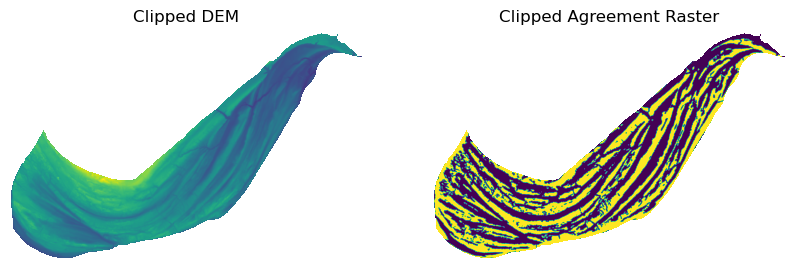

In [3]:
binary_path_out, dem_path_out = create_ridge_area_raster_fs(
    dem_path=dem_path,
    geometry_path=bend_path,
    out_dir=output_dir,
    no_data=np.nan,
    window=RASTER_WINDOW_SIZE,
    dx=1,
    small_feats_size=SMOOTHING_WINDOW_SIZE,
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

dem_clip = rasterio.open(dem_path_out).read(1)
mapper = ax1.imshow(dem_clip)
ax1.set_axis_off()
ax1.set_title("Clipped DEM")

agr_clip = rasterio.open(binary_path_out).read(1)
mapper = ax2.imshow(agr_clip)
ax2.set_axis_off()
ax2.set_title("Clipped Agreement Raster");

# Create Vector Datasets

In [4]:
manual_ridges = gpd.read_file(manual_ridge_path)
cl = gpd.read_file(centerline_path)
packets = gpd.read_file(packet_path).set_index("packet_id")

In [5]:
# Smooth and densify the lines
ls = LineSmoother(manual_ridges, VERTEX_SPACING, SMOOTHING_WINDOW_SIZE)
smooth_ridges = ls.execute()

# Save smooth ridges to disk
output_dir = Path("example_data/output")
smooth_ridge_name = manual_ridge_path.with_stem(
    manual_ridge_path.stem + "_smoothed"
).name
smooth_ridge_path = output_dir / smooth_ridge_name

smooth_ridges.to_file(smooth_ridge_path, driver="GeoJSON", index=False)

# Plot manual and smoothed lines for comparison
m = manual_ridges.explore(color="black", style_kwds={"weight": 5})
smooth_ridges.explore(color="red", m=m)

In [6]:
# define the distance between transects
step = 100

# With a vertex spacing of ~1m, take every `step`th vertex along the centerline
starts = np.asarray(cl.geometry[0].xy).T[::step]

# Transect Parameters
shoot_distance = SHOOT_DISTANCE  # Distance that the N1 coordinate will shoot out from point P1; measured in linear unit of dataset
search_distance = SEARCH_DISTANCE  # Buffer radius used to search for an N2 coordinate on R2; measured in linear unit of dataset
dev_from_90 = DEV_FROM_90  # Max angular deviation from 90° allowed when searching for an N2 coordinate on R2; measured in degrees

transects = create_transects(
    cl, smooth_ridges, step, shoot_distance, search_distance, dev_from_90
)

# Save transects to disk
transect_path = output_dir / f"{bend_id}_transects.geojson"
transects.to_file(transect_path, driver="GeoJSON", index=True)

Generate Transects: 100%|##########| 32/32 [00:06<00:00,  5.11it/s]


# Calculate Ridge Metrics

In [7]:
# Vector Data
ridges = gpd.read_file(smooth_ridge_path)
transects = gpd.read_file(transect_path)
packets = gpd.read_file(packet_path)
cl = gpd.read_file(centerline_path)

# Raster Data
bin_raster = rasterio.open(binary_path_out)
dem = rasterio.open(dem_path_out)

In [8]:
rich_transects, itx = calculate_ridge_metrics(transects, ridges, bin_raster, dem)
itx = itx.loc["LBR_025"]

# Add packets
itx_w_packets = itx.sjoin(packets.drop("bend_id", axis=1))
itx_w_packets = itx_w_packets.reset_index().set_index(
    ["transect_id", "ridge_id", "packet_id"]
)
ridge_metrics_w_packets = itx_w_packets[
    ["ridge_amp", "ridge_width", "pre_mig_dist", "geometry"]
]
ridge_metrics_w_packets.columns = ridge_metrics_w_packets.columns.rename("metrics")

# Save to disk
itx_path = output_dir / f"{bend_id}_intersections.geojson"
ridge_metrics_w_packets.to_file(itx_path, driver="GeoJSON", index=True)

Ridge Metrics: 100%|##########| 25/25 [00:01<00:00, 12.64it/s]


Text(0.5, 1.0, 'Ridge amplitude at each intersection')

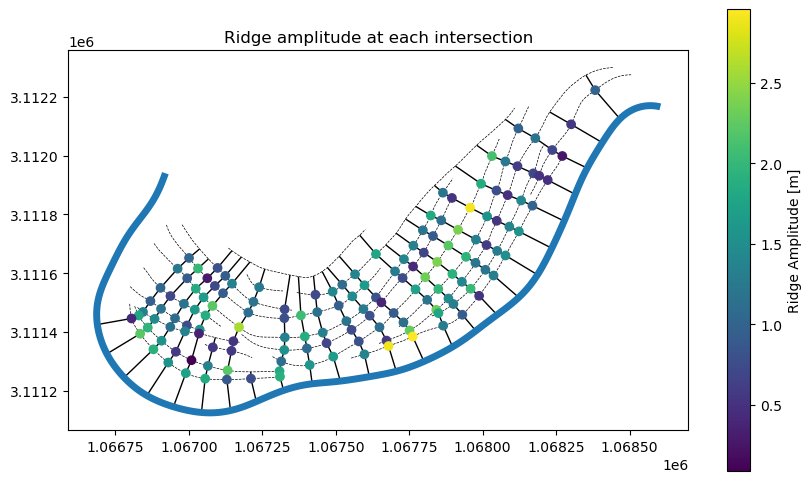

In [9]:
# Plot itx
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ridges.plot(ax=ax, color="k", ls="--", lw=0.5, zorder=0)
transects.plot(ax=ax, color="k", lw=1, zorder=1)
cl.plot(ax=ax, color="tab:blue", lw=5, zorder=2)

itx_w_packets.plot(
    column="ridge_amp",
    ax=ax,
    zorder=2,
    legend=True,
    legend_kwds={"label": "Ridge Amplitude [m]"},
)

ax.set_title("Ridge amplitude at each intersection")